# SmartTicketAI Compact EDA + Training (TF-IDF + LogisticRegression)
- EDA: 
- Train/test split
- TF-IDF + LogisticRegression (probabilities for confidence)
- Save artifacts for API

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

DATA_PATH = Path("../data/ticket_helpdesk_labeled_multi_languages_english_spain_french_german.csv")
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
print(" Data:", DATA_PATH.resolve())
print("Artifacts:", ARTIFACTS_DIR.resolve())

## Load

In [30]:
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head(10))
display(df.tail(5))
display(df.sample(5, random_state=42))

Shape: (200, 8)


,queue,priority,software_used,hardware_used,accounting_category,language,subject,text
0,Hardware,2,NaN,Wireless Mouse,NaN,en,Wireless Mouse suddenly stops working,"Dear Support Team, I've been using the Wireles..."
1,Hardware,2,NaN,IP PBX,NaN,fr,Problème de connexions IP PBX,"Bonjour, nous rencontrons un problème avec not..."
2,Hardware,2,NaN,SFX-Netzteil,NaN,de,Problem mit meinem SFX-Netzteil,"Sehr geehrte Damen und Herren, mein SFX-Netzte..."
3,Accounting,2,NaN,NaN,Customer Inquiries::Technical Support,en,Invoice Adjustment Request,"Dear Customer Support,\nI recently received my..."
4,Software,2,Arbitrum,NaN,NaN,en,Issue with Arbitrum: UI not loading,"Hello Support Team,\nI've been experiencing an..."
5,Software,1,Drug Discovery,NaN,NaN,es,Pregunta sobre actualización Drug Discovery,"Estimados, me gustaría saber si hay alguna act..."
6,Software,3,Adobe Premiere Pro 2021,NaN,NaN,de,Dringendes Problem mit Adobe Premiere Pro 2021,"Hallo Team,Adobe Premiere Pro 2021 stürzt stän..."
7,Accounting,2,NaN,NaN,Employee Inquiries::Technical,fr,Changement d'adresse de facturation souhaité,"Bonjour, pourriez-vous mettre à jour notre adr..."
8,Accounting,2,NaN,NaN,Employee Inquiries::IT Support::Access Rights,fr,Demande de mise à jour des droits d'accès,"Bonjour Service IT, je rencontre des difficult..."
9,Hardware,2,NaN,Portable Console,NaN,en,Issue with Portable Console - Screen flickering,The screen flickers randomly during use.


,queue,priority,software_used,hardware_used,accounting_category,language,subject,text
195,Hardware,1,NaN,Swift Laptop,NaN,es,Pantalla parpadea en Swift Laptop,La pantalla de mi portátil Swift parpadea de v...
196,Software,1,AWS,NaN,NaN,de,Feature-Anfrage: Automatische Backups für AWS,"Hallo Support-Team, ich würde gerne wissen, ob..."
197,Hardware,1,NaN,GPU,NaN,es,Problemas menores con la GPU,"Hola soporte, tengo una tarjeta gráfica GPU qu..."
198,Software,3,Avast Free Antivirus 2021,NaN,NaN,en,[URGENT] Avast Free Antivirus 2021 blocks syst...,"Dear Support Team,\n\nAfter the latest update ..."
199,Hardware,2,NaN,Smart-Tracker,NaN,fr,Le Smart-Tracker ne s'allume plus,"Bonsoir support technique,\nJ’ai un souci avec..."


,queue,priority,software_used,hardware_used,accounting_category,language,subject,text
95,Accounting,2,NaN,NaN,Employee Inquiries::Legal Inquiries::Labor Law,en,Question about labor law lease term notice,"Dear accounting support, can you explain the r..."
15,Hardware,2,NaN,Huion Inspiroy H1060P,NaN,es,Problemas con la conexión de Huion Inspiroy H1...,"Hola equipo de soporte, Estoy teniendo problem..."
30,Accounting,1,NaN,NaN,Customer Inquiries::Security Inquiries,en,Inquiry regarding billing security protocols,"Hello Support Team,\nI would like to inquire a..."
158,Hardware,2,NaN,Smart-Beleuchtung,NaN,en,Smart-Beleuchtung: Probleme mit Verbindung,"Hello Support Team,\nI am experiencing an issu..."
128,Software,3,MicroSIP,NaN,NaN,en,MicroSIP - Failed to Load SIP Account,"Dear Support Team, I am experiencing issues wi..."


## columns, dtypes, nulls, duplicates

Columns: ['queue', 'priority', 'software_used', 'hardware_used', 'accounting_category', 'language', 'subject', 'text']

Dtypes:
 queue                  object
priority                int64
software_used          object
hardware_used          object
accounting_category    object
language               object
subject                object
text                   object
dtype: object

Nulls:
 accounting_category    149
hardware_used          134
software_used          117
queue                    0
priority                 0
language                 0
subject                  0
text                     0
dtype: int64

Duplicate rows: 0


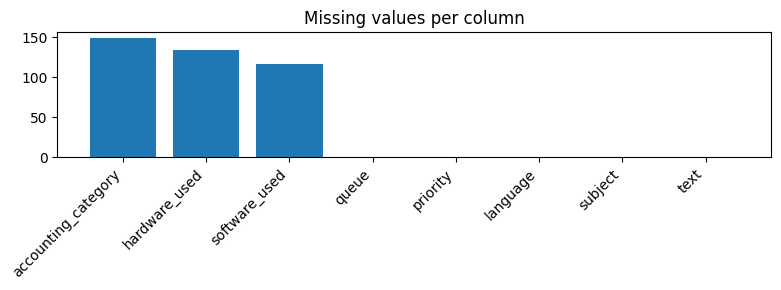

In [31]:
print("Columns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)

nulls = df.isna().sum().sort_values(ascending=False)
print("\nNulls:\n", nulls)
dupes = df.duplicated().sum()
print("\nDuplicate rows:", dupes)

plt.figure(figsize=(8,3))
plt.bar(nulls.index.astype(str), nulls.values)
plt.title("Missing values per column")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Select columns (edit if needed)

In [22]:
TEXT_COL = "text"
LABEL_COL = "queue"
assert TEXT_COL in df.columns and LABEL_COL in df.columns, f"Expected columns {TEXT_COL},{LABEL_COL}, got {df.columns}"

# clean empties
df = df[df[TEXT_COL].notna() & df[LABEL_COL].notna()]
df = df[(df[TEXT_COL].astype(str).str.strip() != "") & (df[LABEL_COL].astype(str).str.strip() != "")]
df = df.drop_duplicates().reset_index(drop=True)
print("Cleaned shape:", df.shape)

Cleaned shape: (200, 8)


## Class balance + graph

queue
Software      83
Hardware      66
Accounting    51
Name: count, dtype: int64

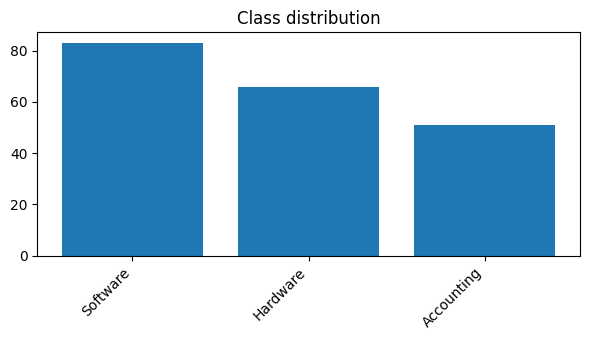

In [32]:
label_counts = df[LABEL_COL].value_counts()
display(label_counts)

plt.figure(figsize=(6,3.5))
plt.bar(label_counts.index.astype(str), label_counts.values)
plt.title("Class distribution")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Text length quick check + graph

Avg tokens: 35.095
         count    mean        std  min    25%   50%    75%   max
_tokens  200.0  35.095  14.656056  6.0  23.75  36.0  46.25  69.0


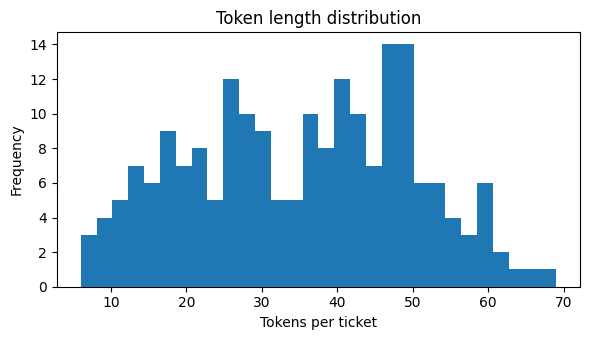

In [33]:
df["_tokens"] = df[TEXT_COL].astype(str).str.split().map(len)
print("Avg tokens:", df["_tokens"].mean())
print(df[["_tokens"]].describe().T)

plt.figure(figsize=(6,3.5))
plt.hist(df["_tokens"], bins=30)
plt.xlabel("Tokens per ticket")
plt.ylabel("Frequency")
plt.title("Token length distribution")
plt.tight_layout()
plt.show()

## Train / Test split

In [34]:
X = df[TEXT_COL].astype(str).values
y = df[LABEL_COL].astype(str).values

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

print("Train:", len(X_train), "Test:", len(X_test))
print("Classes:", list(le.classes_))

Train: 160 Test: 40
Classes: ['Accounting', 'Hardware', 'Software']


## TF-IDF + LogisticRegression (probabilities)

In [ ]:
# multinomial + saga works well with TF-IDF; C can be tuned later
clf = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=60_000, ngram_range=(1,2))),
    ("logreg", LogisticRegression(max_iter=2000, n_jobs=-1, solver="saga", multi_class="multinomial"))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test).max(axis=1)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix plot (plain matplotlib)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=le.classes_, yticklabels=le.classes_,
    xlabel="Predicted", ylabel="True", title="Confusion Matrix"
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
thresh = cm.max()/2 if cm.size else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

## Save artifacts

In [ ]:
model_path = ARTIFACTS_DIR / "ticket_classifier_pipeline.joblib"
labels_path = ARTIFACTS_DIR / "label_encoder.joblib"
meta_path = ARTIFACTS_DIR / "training_meta.json"

joblib.dump(clf, model_path)
joblib.dump(le, labels_path)

import json
with open(meta_path, "w") as f:
    json.dump({
        "accuracy": float(acc),
        "labels": le.classes_.tolist(),
        "text_col": TEXT_COL,
        "label_col": LABEL_COL
    }, f, indent=2)

print("Saved:", model_path.resolve())
print("Saved:", labels_path.resolve())
print("Saved:", meta_path.resolve())

## Quick manual tests

In [36]:
def predict_label(text: str):
    pred_id = clf.predict([text])[0]
    label = le.inverse_transform([pred_id])[0]
    prob = float(clf.predict_proba([text])[0].max())
    return label, prob

examples = [
    "My invoice shows the wrong amount",
    "VPN keeps disconnecting after login",
    "Can you add SSO for our org?"
]
for e in examples:
    print(e, "->", predict_label(e))

My invoice shows the wrong amount -> ('Accounting', 0.3804806433279234)
VPN keeps disconnecting after login -> ('Software', 0.46498642269918844)
Can you add SSO for our org? -> ('Accounting', 0.38254775256553514)
